In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tensorflow.keras import datasets, layers, utils, Sequential, Model
import matplotlib.pyplot as plt

# Utils

In [2]:
(train_x, train_y), (test_x, test_y) = datasets.mnist.load_data()
train_x = train_x.reshape([train_x.shape[0], -1]) / 255.
test_x = test_x.reshape([test_x.shape[0], -1]) / 255.

train_y = utils.to_categorical(train_y, 10)
test_y = utils.to_categorical(test_y, 10)

In [3]:
print(train_x.shape, test_x.shape)

(60000, 784) (10000, 784)


In [4]:
def plot_wb(model, ranges=None):
    
    # Take all layers except last one (because no DSD layers.)
    for i, l in enumerate(model.layers[:-1]):
        # Plot.
        fig = plt.figure(figsize=(15,5))

        fig.add_subplot(1,2,1)
        plt.title("weights " + l.name)
        plt.hist(l.get_weights()[0].flatten(), bins=100, range=ranges);

        fig.add_subplot(1,2,2)
        plt.title("biases " + l.name)
        plt.hist(l.get_weights()[1].flatten(), bins=100, range=ranges);

def wb_non_zero_percentage(model):
    pos_last_layer = len(model.layers) - 1

    for i, l in enumerate(model.layers):

        # Take all dense layer except last one,
        if i != pos_last_layer and  i % 2 == 0:
            w, b = model.layers[0].get_weights()

            non_zero_w = tf.math.count_nonzero(w)
            total_w = tf.reshape(w, [-1]).shape[0]
            res_w = (non_zero_w / total_w).numpy() * 100

            non_zero_b = tf.math.count_nonzero(w)
            total_b = tf.reshape(w, [-1]).shape[0]
            res_b = (non_zero_b / total_b).numpy() * 100

            print("Percentage of non-zero value " + l.name + ": w = {} | b = {}".format(res_w, res_b))

# Model creation

In [5]:
#TODO: When creating NN model, can't access weights because it wasn't initialize yet.
# 

In [6]:
class NN(Model):
    def __init__(self, inputs_shape= 28 * 28, sparsity=0.5):
        super(NN, self).__init__()
        
        #self.is_train_on_sparse = tf.Variable(False)
        self.is_train_on_sparse = False
        
        self.inputs_shape = inputs_shape
        self.sparsity = sparsity
        
        self.fc1 = layers.Dense(512, activation="relu", kernel_initializer='glorot_uniform')
        self.fc2 = layers.Dense(256, activation="relu", kernel_initializer='glorot_uniform')
        self.fc3 = layers.Dense(128, activation="relu", kernel_initializer='glorot_uniform')
        self.fc4 = layers.Dense(10, activation="softmax", kernel_initializer='glorot_uniform')
        
        self.dense_layers_with_dsd = [self.fc1, self.fc2, self.fc3]
        
    def reset_masks(self):
        self.masks = []
        
        for layer in self.dense_layers_with_dsd:
            
            w, b = layer.get_weights()
            #tf_w = tf.Variable(np.ones_like(w))
            #tf_b = tf.Variable(np.ones_like(b))
            
            self.masks.append([tf.ones_like(w), tf.ones_like(b)])
        
        return self.masks
    
        
    def prune_layers(self):
    
        for i, (layer, (w, b)) in enumerate(zip(self.dense_layers_with_dsd, self.masks)):
            
            # This return a Tensor while get_weights() return np.array.
            curr_wb = layer.weights
            
            # Get pruning masks
            # Weight
            qk = tfp.stats.percentile(tf.math.abs(curr_wb[0]), q = self.sparsity * 100)
            mask_w = tf.where(tf.math.abs(curr_wb[0]) < qk, 0., 1.)

            # Bias
            qk = tfp.stats.percentile(tf.math.abs(curr_wb[1]), q = self.sparsity * 100)
            mask_b = tf.where(tf.math.abs(curr_wb[1]) < qk, 0., 1.)
            
            # Keep track of masks for "Training on Sparse" step.
            self.masks[i][0] = mask_w
            self.masks[i][1] = mask_b
            
            # Apply masks to each weights/biases layer.
            curr_wb[0].assign(curr_wb[0] * mask_w)
            curr_wb[1].assign(curr_wb[1] * mask_b)
            
            layer.set_weights((curr_wb[0].numpy(), curr_wb[1].numpy()))
            
    
    #def activate_train_on_sparse(self):
    #    self.is_train_on_sparse.assign(True)
        
    #def deactivate_train_on_sparse(self):
    #    self.is_train_on_sparse.assign(False)
    
    def stop_gradients(self, layer_idx, masks):
        
        # Get layer weights/biases at a given index.
        layer = self.dense_layers_with_dsd[layer_idx]
        wb = layer.weights
        
        # Apply masks to each weights/biases at a given layer
        wb[0].assign(wb[0] * self.masks[layer_idx][0])
        wb[1].assign(wb[1] * self.masks[layer_idx][1])
            
        #layer.set_weights((wb[0].numpy(), wb[1].numpy()))
    
    def call(self, x):
        
        x = self.fc1(x)
        #x = tf.cond(self.is_train_on_sparse, lambda: tf.stop_gradient(x * self.masks[0][0]), lambda: x)
        if self.is_train_on_sparse:
            self.stop_gradients(0, self.masks)
        
        x = self.fc2(x)
        #x = tf.cond(self.is_train_on_sparse, lambda: tf.stop_gradient(x * self.masks[1][0]), lambda: x)
        if self.is_train_on_sparse:
            self.stop_gradients(1, self.masks)
            
        x = self.fc3(x)
        #x = tf.cond(self.is_train_on_sparse, lambda: tf.stop_gradient(x * self.masks[2][0]), lambda: x)
        if self.is_train_on_sparse:
            self.stop_gradients(2, self.masks)
    
        x = self.fc4(x)
        return x

    def build_model(self):
        x = layers.Input(shape=self.inputs_shape)
        return Model(inputs=[x], outputs = self.call(x))        

In [7]:
sparsity_global_variable = 0.25

model = NN(sparsity=sparsity_global_variable)
model.build_model()#.summary()
model.reset_masks()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# I/ Training

In [8]:
model.fit(train_x, train_y, epochs=1, workers=1)

1875/1875 [==============================] - 18s 9ms/step - loss: 0.3271 - accuracy: 0.9024


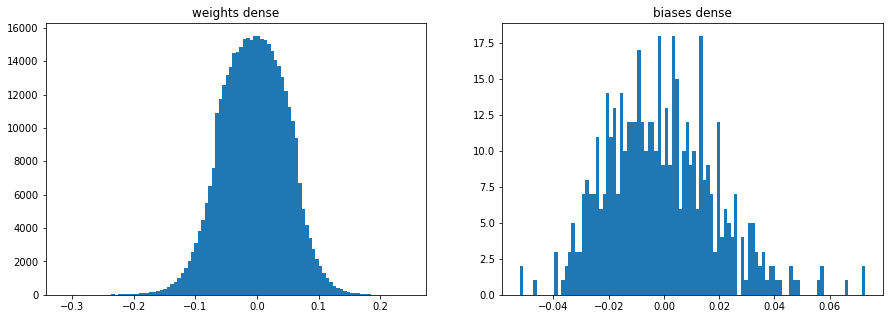

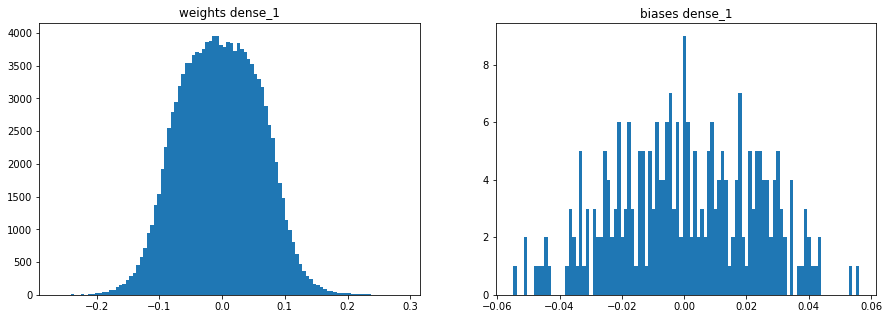

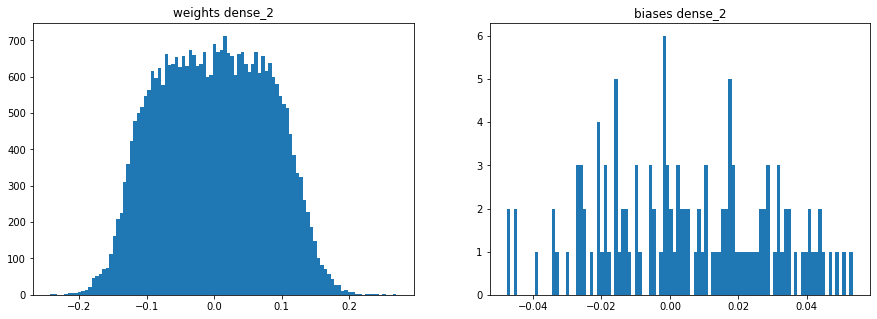

In [9]:
plot_wb(model)

# II/ Prune the network

In [10]:
model.prune_layers()

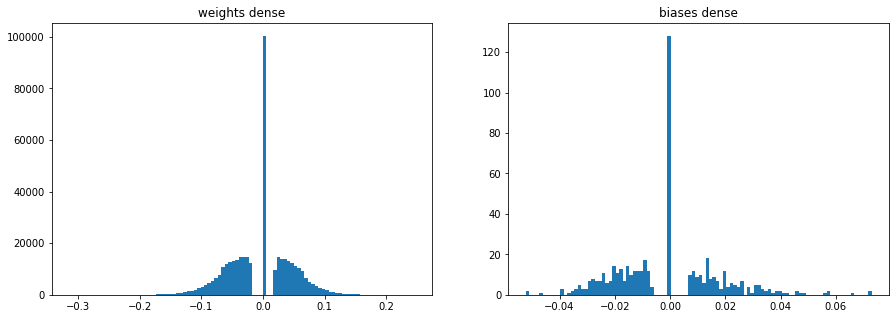

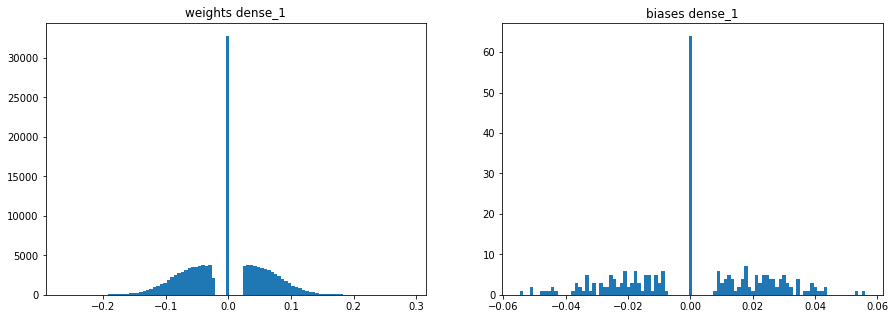

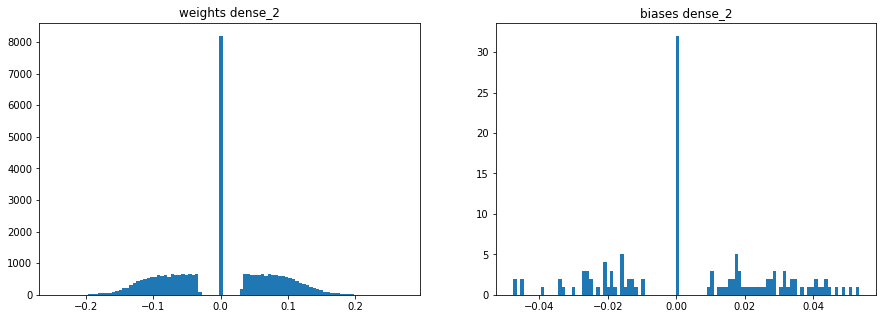

In [11]:
plot_wb(model)

In [12]:
wb_non_zero_percentage(model)

Percentage of non-zero value dense: w = 75.0 | b = 75.0
Percentage of non-zero value dense_2: w = 75.0 | b = 75.0


# III/ Train on Sparse

In [13]:
# model.layers[1].sparse_training = True
# model.layers[3].sparse_training = True
# model.layers[5].sparse_training = True
model.is_train_on_sparse = True

In [14]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_x, train_y, epochs=1)

1875/1875 [==============================] - 13s 6ms/step - loss: 0.0801 - accuracy: 0.9752


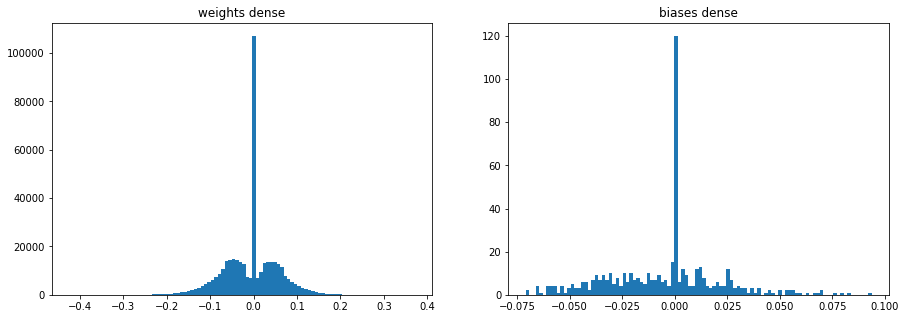

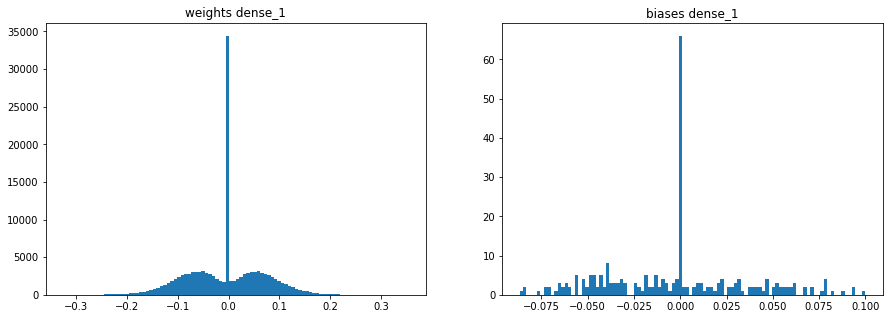

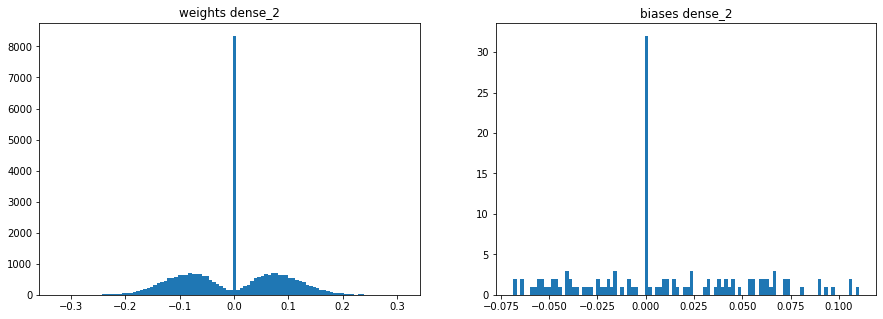

In [15]:
plot_wb(model)

In [16]:
wb_non_zero_percentage(model)

Percentage of non-zero value dense: w = 93.43710140306123 | b = 93.43710140306123
Percentage of non-zero value dense_2: w = 93.43710140306123 | b = 93.43710140306123
